In [1]:
from glob import glob
from os import path

import numpy as np
from scipy.io import wavfile
import librosa
from librosa.feature import mfcc


ms = 1.0e-3
noise_paths = glob('../data/Snoring_Dataset_Khan_2019/0/*.wav')
snore_paths = glob('../data/Snoring_Dataset_Khan_2019/1/*.wav')
paths = noise_paths + snore_paths
x = []
y = [0] * len(noise_paths) + [1] * len(snore_paths)

for fpath in paths:
    sample_rate, data = wavfile.read(fpath)
    
    # it could be a multi-channel audio
    data = data if len(data.shape) == 1 else data[:, 0]
    
    hop_length = int(31.27 * ms * sample_rate)
    n_fft = int(np.ceil(50 * ms * sample_rate / 512) * 512)
    
    norm_audio = data / max(np.max(np.abs(data)), 1)
    features = mfcc(y=norm_audio, sr=sample_rate, n_mfcc=32, hop_length=hop_length, n_fft=n_fft)
    x.append(features)

orig_x = np.asarray([t[:32, :32] for t in x])
orig_y = np.asarray(y)


/tmp/ipykernel_5023/4004940713.py:18: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(fpath)


In [2]:
from sklearn.model_selection import train_test_split

# test siz = 100, valid size = 100, train size = the rest of it
# note that these are all lists yet!
rest_x, test_x, rest_y, test_y = train_test_split(orig_x, orig_y, test_size=100)
train_x, valid_x, train_y, valid_y = train_test_split(rest_x, rest_y, test_size=100)

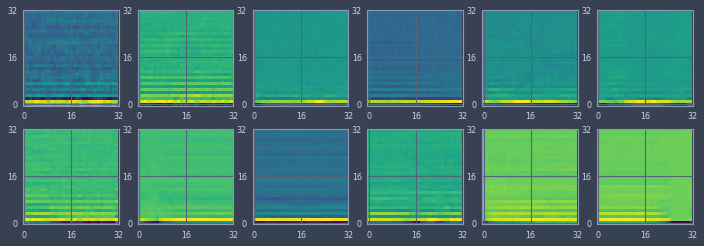

In [3]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

%matplotlib inline

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='oceans16')


def show_samples(test_x, test_y):
    noise_idx = np.where([y == 0 for y in test_y])[0]
    snore_idx = np.where([y == 1 for y in test_y])[0]

    num_samples = 6
    fig, ax = plt.subplots(2, num_samples, figsize=(12, 4))

    for row, indices in zip(ax, [noise_idx, snore_idx]):
        for ax, idx in zip(row,  indices):
            ax.imshow(test_x[idx], origin='lower', interpolation='nearest')

            ax.set_xticks([0, 16, 32])
            ax.set_yticks([0, 16, 32])

            for l in ax.get_xticklabels() + ax.get_yticklabels():
                l.set_fontsize(8)

                
show_samples(test_x, test_y)
# ax.set_xlabel('frame')
# ax.set_ylabel('MFCC features')


In [3]:
import sys
from os import path

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

sys.path.append(path.join('..', 'src'))
from model_khan import SnoreModel


device = 'cuda' if torch.cuda.is_available() else 'cpu'


class SnoreDataset(Dataset):
    def __init__(self, x, y):
        """
        x: MFCC features
        y: labels, (1 -> snore, 0 -> non-snore)
        
        Args:
            x: shape = (# of samples, 32, 32)
            y: shape = (# of samples,)"""
        self.x = torch.unsqueeze(torch.tensor(x).float(), dim=1)
        self.y = torch.unsqueeze(torch.tensor(y).float(), dim=1)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]
        

def get_model():
    """Construct a model and corresponding optimizer and loss function
    
    Returns:
        (Model, Adam, BCELoss)"""
    snore_model = SnoreModel().to(device)
    optimizer = Adam(snore_model.parameters())
    loss_fn = nn.BCELoss()
    
    return snore_model, optimizer, loss_fn


def get_data():
    """
    Returns:
        (DataLoader, DataLoader): train and validation DataLoaders
    """
    train_dataset = SnoreDataset(train_x, train_y)
    train_dl = DataLoader(train_dataset, batch_size=10)

    valid_dataset = SnoreDataset(valid_x, valid_y)
    valid_dl = DataLoader(valid_dataset, batch_size=10)
    
    return train_dl, valid_dl


def train_batch(batch_x, batch_y, model, optimizer, loss_fn):
    model.train()
    
    # here x and y to device
    prediction = model(batch_x.to(device))
    batch_loss = loss_fn(prediction, batch_y.to(device))
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return batch_loss.item()


@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x.to(device))
    is_correct = (prediction > 0.5) == y.to(device)
    
    return is_correct.cpu().numpy().tolist()

In [4]:
model, optimizer, loss_fn = get_model()
train_dl, valid_dl = get_data()

train_accuracies = []
valid_accuracies = []

epochs = 50

for epoch in range(epochs):
    train_epoch_accuracies = []
    valid_epoch_accuracies = []
    
    for x, y in train_dl:
        train_batch(x, y, model, optimizer, loss_fn)
    
    # accuracy on the train data
    for x, y in train_dl:
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_accuracies.append(np.mean(train_epoch_accuracies))

    # accuracy on the validation data
    for x, y in valid_dl:
        is_correct = accuracy(x, y, model)
        valid_epoch_accuracies.extend(is_correct)
    valid_accuracies.append(np.mean(valid_epoch_accuracies))

    print(f'epoch: {epoch + 1:4d} / {epochs:4d}', end='\r')

In [12]:
for x, y in train_dl:
    x = np.random.randn(1, 1, 32, 32)
    print(model(x.to(device)).shape)

torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([10, 1])
torch.Size([10, 1, 32, 32])
torch.Size([

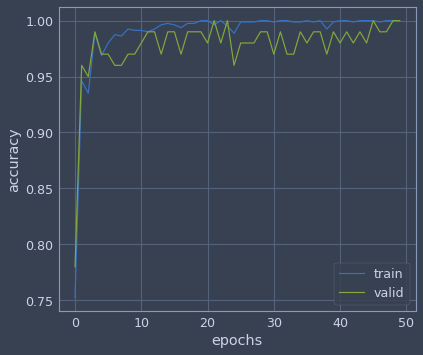

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_accuracies, label='train')
ax.plot(valid_accuracies, label='valid')

ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')

ax.legend(loc='lower right')

In [7]:
test_dataset = SnoreDataset(test_x, test_y)
test_dl = DataLoader(test_dataset, batch_size=10)

test_accuracies = []

model.eval()
for x, y in test_dl:
    test_accuracies.extend(accuracy(x, y, model))

print('test accuracy:', np.mean(test_accuracies))

test accuracy: 0.96


In [8]:
torch.save(model.state_dict(), 'snore_model_epoch_50.pt')

#### 1. KFold `n_split=9`
- 900 train and validation samples
- 100 test samples

In [9]:
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler


def kfold_validations(n_splits, epochs, batch_size, rest_x, rest_y):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    tv_dataset = SnoreDataset(rest_x, rest_y)

    train_fold_accuracies = []
    valid_fold_accuracies = []

    # KFold.split() gives a generator
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(np.arange(rest_x.shape[0]))):
        # new model for each fold
        model, optimizer, loss_fn = get_model()

        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(valid_idx)

        train_dl = DataLoader(tv_dataset, batch_size=batch_size, sampler=train_sampler)
        valid_dl = DataLoader(tv_dataset, batch_size=batch_size, sampler=test_sampler)

        # accuracies as a function of number of training epochs
        # how validation accuracies evolve?
        train_epoch_accuracies = []
        valid_epoch_accuracies = []

        for epoch in range(epochs):
            # train
            model.train()
            for batch_x, batch_y in train_dl:
                prediction = model(batch_x.to(device))
                batch_loss = loss_fn(prediction, batch_y.to(device))
                batch_loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            # train accuracy after an epoch
            train_accuracies = []
            for batch_x, batch_y in train_dl:
                train_accuracies.extend(accuracy(batch_x, batch_y, model))
            train_epoch_accuracies.append(np.mean(train_accuracies))

            # validation accuracy after an epoch
            valid_accuracies = []
            for batch_x, batch_y in valid_dl:
                valid_accuracies.extend(accuracy(batch_x, batch_y, model))
            valid_epoch_accuracies.append(np.mean(valid_accuracies))

            print(f'fold: {fold + 1:3d} / {n_splits:3d}, epoch: {epoch + 1:4d} / {epochs:4d}', end='\r')

        train_fold_accuracies.append(train_epoch_accuracies)
        valid_fold_accuracies.append(valid_epoch_accuracies)
        
    return train_fold_accuracies, valid_fold_accuracies


n_splits = 9
epochs = 50
batch_size = 10

train_fold_accuracies, valid_fold_accuracies = kfold_validations(n_splits, epochs, batch_size,
                                                                 rest_x, rest_y)


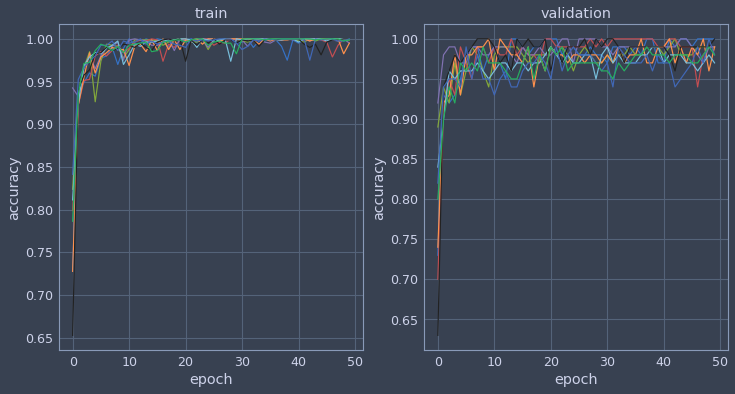

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, accuracies, title in zip(axes,
                                 [train_fold_accuracies, valid_fold_accuracies],
                                 ['train', 'validation']):
    for a in accuracies:
        ax.plot(a)
    
    ax.set_title(title)
    
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')


In [13]:
np.mean([a[-1] for a in valid_fold_accuracies]), np.min([a[-1] for a in valid_fold_accuracies])

(0.9877777777777779, 0.97)

#### 2. Normalized audio by its max of abs
- some of audio files are complete silent
- as long as its max of abs is not too small (0.001)

In [14]:
x = []
y = [0] * len(noise_paths) + [1] * len(snore_paths)

for fpath in paths:
    sample_rate, data = wavfile.read(fpath)
    
    data = data if len(data.shape) == 1 else data[:, 0]
    hop_length = int(31.27 * ms * sample_rate)
    n_fft = int(np.ceil(50 * ms * sample_rate / 512) * 512)
    
    norm_audio = data / max(np.max(np.abs(data)), 1e-3)
    features = mfcc(y=norm_audio, sr=sample_rate, n_mfcc=32, hop_length=hop_length, n_fft=n_fft)
    x.append(features)

norm_x = np.asarray([t[:32, :32] for t in x])
norm_y = np.asarray(y)

/tmp/ipykernel_5981/2555736774.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(fpath)


In [13]:
%timeit mfcc(y=norm_audio, sr=sample_rate, n_mfcc=32, hop_length=hop_length, n_fft=n_fft)

10.2 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
norm_rest_x, test_x, norm_rest_y, test_y = train_test_split(norm_x, norm_y, test_size=100)

train_fold_accuracies, valid_fold_accuracies = kfold_validations(n_splits, epochs, batch_size,
                                                                 norm_rest_x, norm_rest_y)


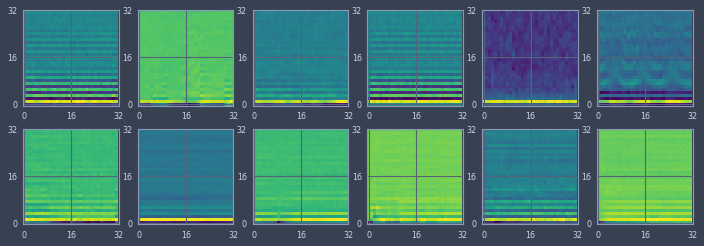

In [17]:
show_samples(norm_rest_x, norm_rest_y)

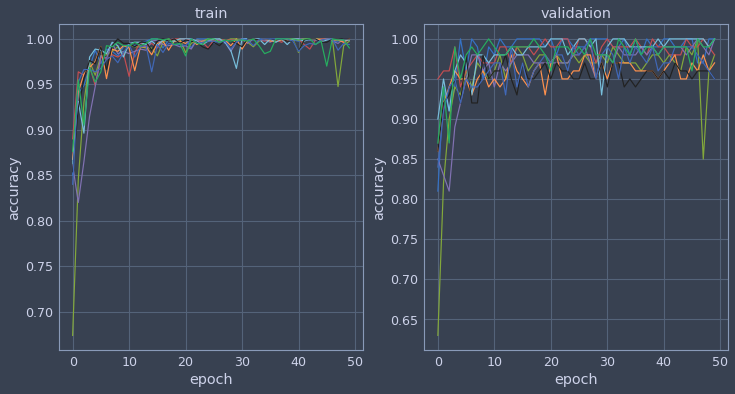

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, accuracies, title in zip(axes,
                                 [train_fold_accuracies, valid_fold_accuracies],
                                 ['train', 'validation']):
    for a in accuracies:
        ax.plot(a)
    
    ax.set_title(title)
    
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')